In [144]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
import contextily as ctx
import pandas as pd
import matplotlib.ticker as ticker

pio.renderers.default = "iframe"

This notebook focuses on comparing and contrasting NYC Covid Wastewater data published by the CDC and NYC Open Data. The primary goal is to develop a mapping between the unique watershed identifiers used by each dataset -- while NYC Open Data provides names, the CDC uses anonymized numeric ids for the 14 watersheds. 

# Getting to know our wastewater treament locations

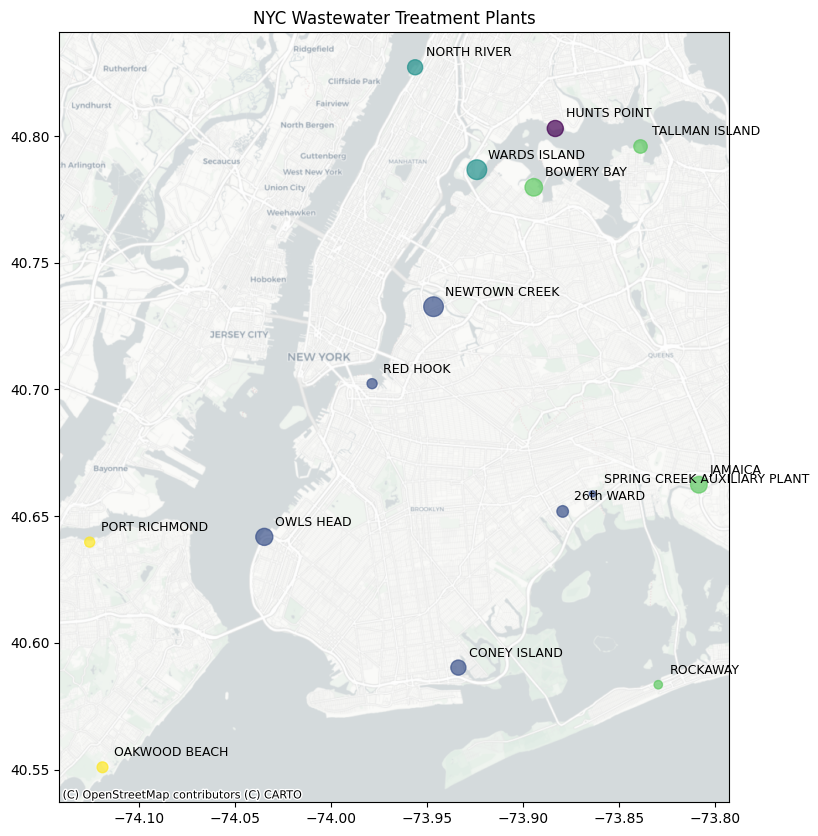

In [117]:
plant_to_borough_mapping = {
    "26th WARD": "KINGS",
    "BOWERY BAY": "QUEENS",
    "CONEY ISLAND": "KINGS",
    "HUNTS POINT": "BRONX",
    "JAMAICA": "QUEENS",
    "NEWTOWN CREEK": "KINGS",
    "NORTH RIVER": "NEW YORK",
    "OAKWOOD BEACH": "RICHMOND",
    "OWLS HEAD": "KINGS",
    "PORT RICHMOND": "RICHMOND",
    "RED HOOK": "KINGS",
    "ROCKAWAY": "QUEENS",
    "SPRING CREEK AUXILIARY PLANT": "KINGS",  # experimental plant, not in COVID data
    "TALLMAN ISLAND": "QUEENS",
    "WARDS ISLAND": "NEW YORK",
}
# this mapping categorizes the plants by address, but perhaps more relevant is their catchment area -- sometimes, but not always, segmented by borough. maybe administrative boundaries aren't useful here.


def add_borough(shapefile_path="/Users/kadye/Code/nyc_wastewater/data/plants_shp/wastewater_treatment_plants.shp"):
    plants_gdf = geopandas.read_file(shapefile_path)
    plants_gdf = plants_gdf.rename(columns={"item_id":"source_id"})
    plants_gdf["borough"] = plants_gdf["source_id"].map(plant_to_borough_mapping)
    return plants_gdf


def map_nyc_wastewater_locations(shapefile_path="/Users/kadye/Code/nyc_wastewater/data/plants_shp/wastewater_treatment_plants.shp"):
    plants_gdf = add_borough(shapefile_path)
    plants_gdf["population"] = plants_gdf.population.str.replace(",", "").fillna(1).astype("int")

    min_size = 20
    max_size = 200
    max_pop = plants_gdf["population"].max()

    marker_sizes = [min_size + (pop / max_pop) * (max_size - min_size) for pop in plants_gdf["population"]]

    ax = plants_gdf.plot(figsize=(10, 10), alpha=0.7, markersize=marker_sizes, column="borough", legend=False, cmap="viridis")

    for idx, row in plants_gdf.iterrows():
        x, y = row.geometry.x, row.geometry.y

        ax.annotate(text=row["source_id"], xy=(x, y), xytext=(8, 8), textcoords="offset points", fontsize=9)
    ctx.add_basemap(ax, crs=plants_gdf.crs, source=ctx.providers.CartoDB.Positron)
    plt.title("NYC Wastewater Treatment Plants")

    plt.show()
    return plants_gdf


plants_gdf = map_nyc_wastewater_locations()

# CDC Data

Since release in 2021, the CDC has been the primary provider of COVID Wastewater data, coercing diverse datasets from around the country into a standard format and methodology. However, the documentation is relatively limited, leaving us to hypothesize about the exact methodology. Additionally, it uses its own wastewater treatment plant IDs, and does not provide names, so in order to report on an individual plant level, we'd like to impute the name of the plant where possible.

In [134]:
def get_cdc_data(url="https://data.cdc.gov/api/views/2ew6-ywp6/rows.csv"):
    df = pd.read_csv(url)
    df = df[df.wwtp_jurisdiction == "New York City"]
    df["test_date"] = pd.to_datetime(df.date_end)
    df = df.drop(["first_sample_date", "reporting_jurisdiction", "sample_location", "sample_location_specify", "county_fips", "detect_prop_15d", "sampling_prior"], axis=1)
    df = df.rename(columns={'county_names':'borough', 'wwtp_id':'source_id', 'population_served':'population'})
    df['borough'] = df['borough'].str.upper()
    return df

In [135]:
cdc_df = get_cdc_data()

There are 14 watersheds, which matches the number of watersheds that the city reports (excluding the experiemental Spring Creek Watershed). The distribution by borough is also the same, making me quite confident that these two datasets describe the same cohort of watersheds, and are therefore suitable for one to one matching.


In [ ]:
cdc_df.groupby('source_')

,wwtp_jurisdiction,source_id,key_plot_id,borough,population,date_start,date_end,ptc_15d,percentile,test_date
7529,New York City,2766,NWSS_ny_2766_Treatment plant_raw wastewater,QUEENS,131254,2023-02-21,2023-03-07,NaN,96.0,2023-03-07
7530,New York City,2766,NWSS_ny_2766_Treatment plant_raw wastewater,QUEENS,131254,2023-02-22,2023-03-08,NaN,96.0,2023-03-08
7531,New York City,2766,NWSS_ny_2766_Treatment plant_raw wastewater,QUEENS,131254,2023-02-23,2023-03-09,NaN,96.0,2023-03-09
7532,New York City,2766,NWSS_ny_2766_Treatment plant_raw wastewater,QUEENS,131254,2023-02-24,2023-03-10,NaN,96.0,2023-03-10
7533,New York City,2766,NWSS_ny_2766_Treatment plant_raw wastewater,QUEENS,131254,2023-02-25,2023-03-11,NaN,96.0,2023-03-11


In [140]:
matching_df = pd.concat([plants_gdf.assign(source="plants")[["source_id", "borough", "population", "source"]], cdc_df.groupby('source_id').last().reset_index().assign(source="cdc")[["source_id", "borough", "population", "source"]]])
matching_df


,source_id,borough,population,source
0,OWLS HEAD,KINGS,800000,plants
1,RED HOOK,KINGS,200000,plants
2,CONEY ISLAND,KINGS,600000,plants
3,OAKWOOD BEACH,RICHMOND,250000,plants
4,SPRING CREEK AUXILIARY PLANT,KINGS,1,plants
5,PORT RICHMOND,RICHMOND,200000,plants
6,NORTH RIVER,NEW YORK,600000,plants
7,WARDS ISLAND,NEW YORK,1100000,plants
8,HUNTS POINT,BRONX,700000,plants
9,ROCKAWAY,QUEENS,100000,plants


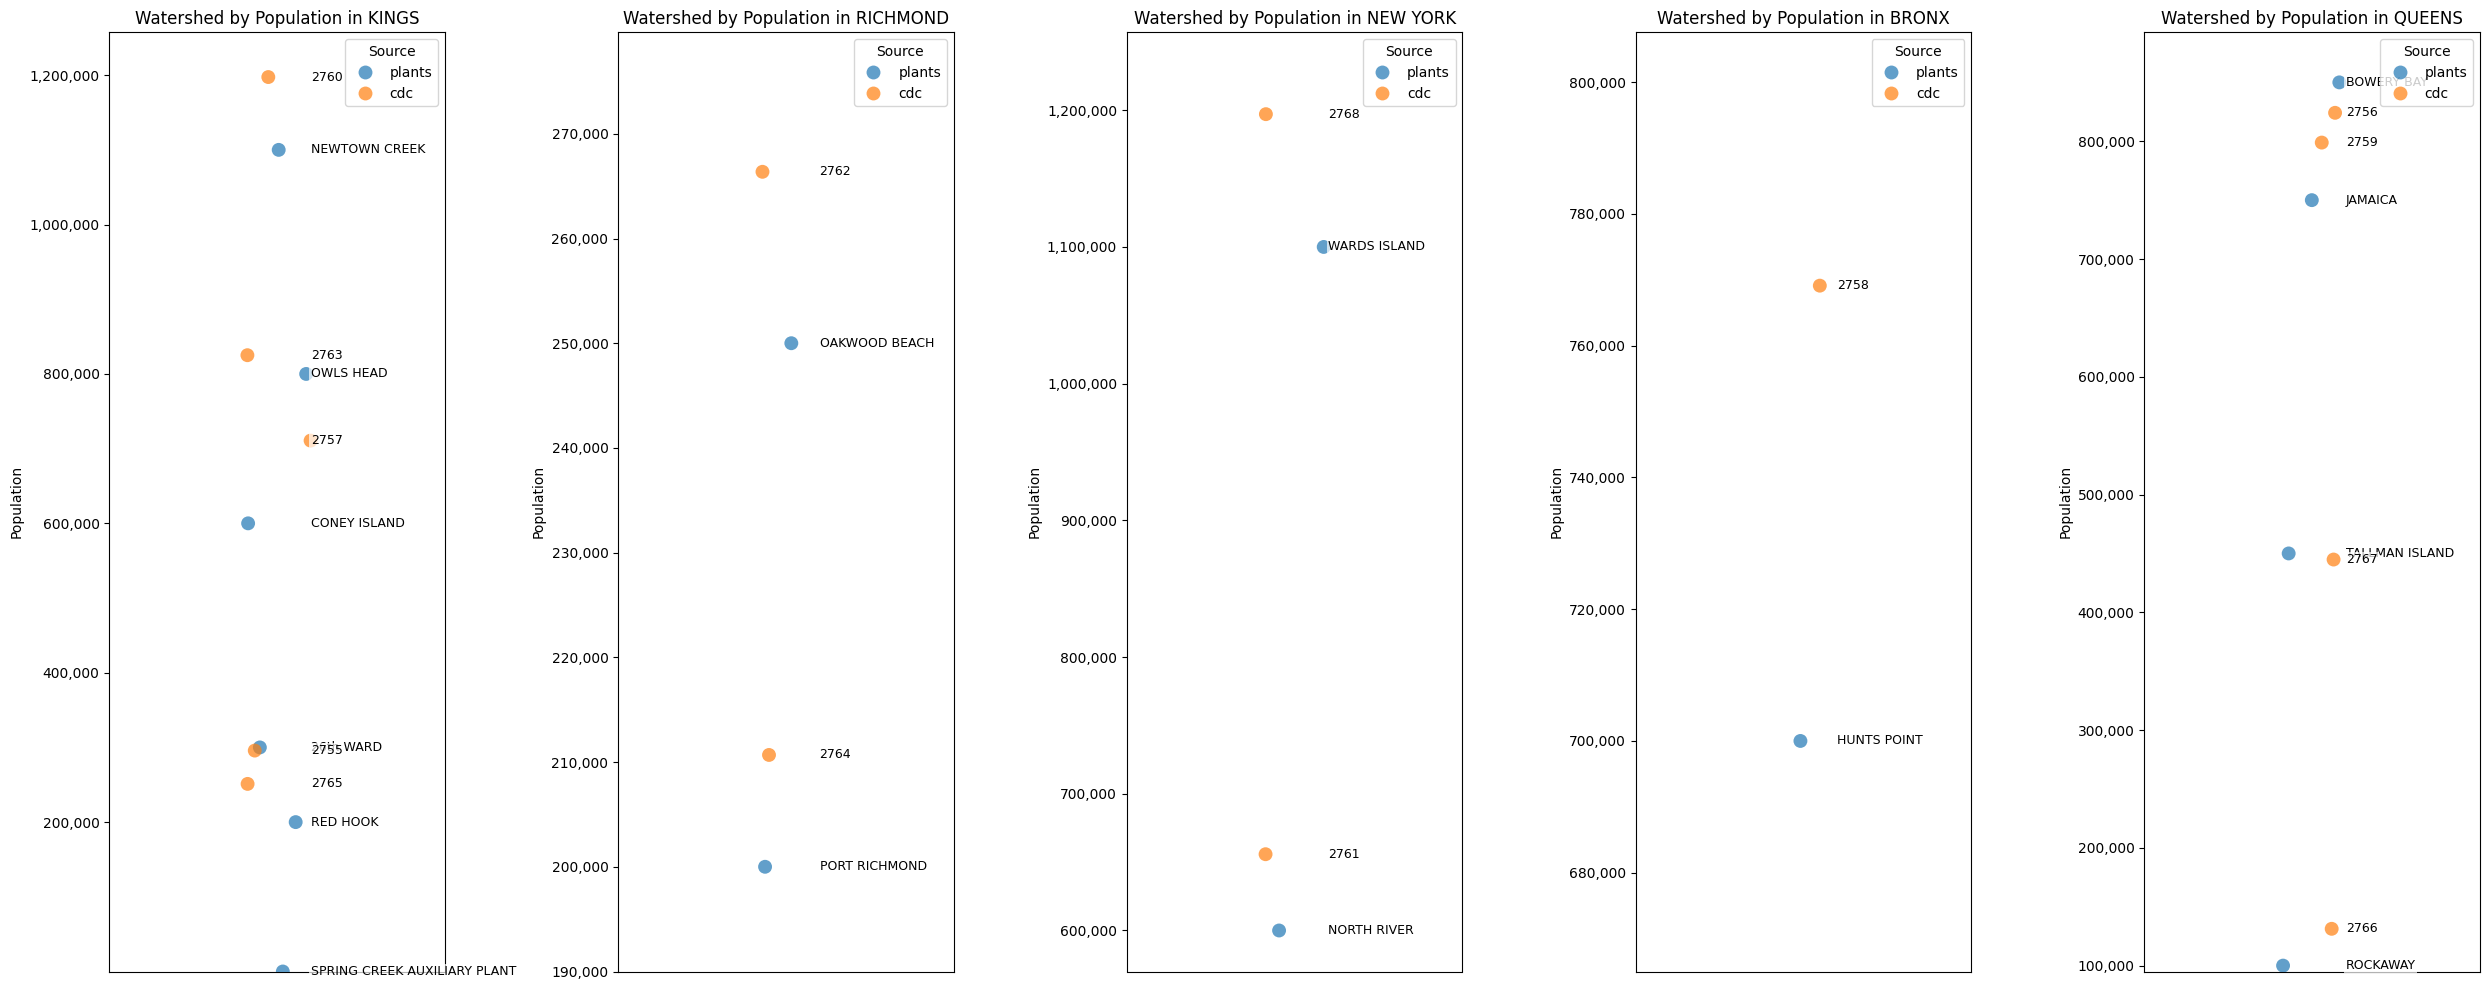

In [ ]:
boroughs = matching_df['borough'].unique()
fig, axes = plt.subplots(1, len(boroughs), figsize=(5 * len(boroughs), 10))

# If there's only one borough, wrap axes in a list
if len(boroughs) == 1:
    axes = [axes]

# Create a plot for each borough
for i, borough in enumerate(boroughs):
    # Filter data for this borough
    borough_data = matching_df[matching_df['borough'] == borough]
    
    # Create a vertical strip plot
    sns.stripplot(
        data=borough_data,
        y='population',  # Now using y for population (vertical)
        x=[0] * len(borough_data),  # Fixed x position
        hue='source',
        ax=axes[i],
        jitter=True,
        size=10,
        alpha=0.7
    )
    
    # Calculate x positions with offset to avoid label overlap
    text_positions = {}
    for j, row in borough_data.iterrows():
        pop = row['population']
        # Check if we have nearby points and adjust position accordingly
        if pop in text_positions:
            text_positions[pop] += 0.1  # Shift position
        else:
            text_positions[pop] = 0.1  # Initial position
        
        # Add text labels for each point
        axes[i].text(
            text_positions[pop],  # Offset x position to avoid overlap
            row['population'],    # Y position 
            str(row['source_id']),
            ha='left',
            va='center',
            fontsize=9,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)  # Add text background
        )
    
    # Set plot title and labels
    axes[i].set_title(f'Watershed by Population in {borough}')
    axes[i].set_ylabel('Population')
    axes[i].set_xlabel('')  # No x-axis label needed
    axes[i].get_xaxis().set_visible(False)  # Hide x-axis
    
    # Format y-axis to avoid scientific notation
    axes[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    # Set reasonable limits for the plot
    y_min = borough_data['population'].min() * 0.95
    y_max = borough_data['population'].max() * 1.05
    axes[i].set_ylim(y_min, y_max)
    
    # Move legend to a better position
    axes[i].legend(title='Source', loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
wwtp_id_to_plant_name_mapping = {
    2758:"HUNTS POINT",
    
}

# NYC data exploration

In [ ]:
wwtp_mapping = {
    "26th Ward": 485,
    "Bowery Bay": 487,
    "Coney Island": 541,
    "Hunts Point": 498,
    "Jamaica Bay": 545,
    "Newtown Creek": 549,
    "North River": 500,  # JUST PICKING ONE FOR NOW, COULD BE 509
    "Oakwood Beach": 550,
    "Owls Head": 551,
    "Port Richmond": 552,
    "Red Hook": 553,
    "Rockaway": 503,
    "Tallman Island": 505,
    "Wards Island": 509,  # JUST PICKING ONE FOR NOW, COULD BE 500
}

wwtp_county_mapping = {485: "Kings", 487: "Queens", 498: "Bronx", 500: "New York", 503: "Queens", 505: "Queens", 509: "New York", 541: "Kings", 545: "Queens", 549: "Kings", 550: "Richmond", 551: "Kings", 552: "Richmond", 553: "Kings"}

In [ ]:
def get_nyc_data(url):
    df = pd.read_csv(url)
    df["test_date"] = pd.to_datetime(df["Test date"])
    df["wwtp_id"] = df["WRRF Name"].map(wwtp_mapping)
    df = df.drop(["WRRF Abbreviation", "Sample Date"], axis=1)
    # ADD NEW ANNOTATION REVIEW FLOW
    df = df.rename(
        columns={
            "Technology": "technology",
            "Sample date": "sample_date",
            "WRRF Name": "wrrf_name",
            "Concentration SARS-CoV-2 gene target (N1 Copies/L) ": "covid_conc",
            "Per capita SARS-CoV-2 load (N1 copies per day per population)": "per_capita_covid_conc",
            "Annotation": "annotation",
            "Population Served, estimated ": "pop_serv_est",
        }
    )
    df = df[
        ~df.annotation.isin(
            [
                "Possible analytical issue",
                "Concentration below Method Limit of Detection",
                "No signal detected; possible analytical issue",
                "No sample delivery due to logistical issue",
                "Sample was not analyzed due to ongoing study with NYC-DOHMH",
                "Analytical issue",
                "Concentration below Method Limit of Quantification (above Method Limit of Detection)",
                "This result is not useable (because associated with contaminated method blank)",
                "Concentration below Method Limit of Quantification (above Method Limit of Detection)",
                "Sample exhibited unusual (redish) color upon arrival.",
                "This batch of samples was not analyzed due to short of staff.",
            ]
        )
    ]
    return df

In [ ]:
def get_nyc_perc_dPCR(df):
    df = df[df["technology"] == "dPCR"]
    df["cum_max"] = df.groupby("wwtp_id")["covid_conc"].cummax()
    rolling = df.set_index("test_date").groupby("wwtp_id")["covid_conc"].rolling("14D").mean().reset_index().rename(columns={"covid_conc": "covid_conc_14d"})
    df = pd.merge(df, rolling, on=["test_date", "wwtp_id"])
    df["est_percentile"] = np.round((df["covid_conc_14d"] / df["cum_max"]) * 100, 1)
    return df

In [ ]:
def get_nyc_perc_RTPCR(df):
    df = df[df["technology"] == "RT-qPCR"]
    # df['covid_conc_adj'] = df['covid_conc'] * 15
    df["cum_max"] = df.groupby("wwtp_id")["covid_conc"].cummax()
    rolling = df.set_index("test_date").groupby("wwtp_id")["covid_conc"].rolling("14D").mean().reset_index().rename(columns={"covid_conc": "covid_conc_14d"})
    df = pd.merge(df, rolling, on=["test_date", "wwtp_id"])
    df["est_percentile"] = np.round((df["covid_conc_14d"] / df["cum_max"]) * 100, 1)
    return df

In [ ]:
def nyc_main(url="https://data.cityofnewyork.us/api/views/f7dc-2q9f/rows.csv", rtpcr=False):
    # Wait for burn in period before using both datasets, official cut over to dpcr is March 2023
    # Eliminate data from before Spring 2021, because the percentile methodology was inconsistant
    nyc_df = get_nyc_data(url)
    if rtpcr:  # NYC Open Data has deprecated dual reporting of RTPCR and DPCR readings as of 2024-03-15
        rtpcr_df = get_nyc_perc_RTPCR(nyc_df)
        dpcr_df = get_nyc_perc_dPCR(nyc_df)
        df = pd.merge(dpcr_df[dpcr_df.test_date > "2023-01-01"], rtpcr_df[(rtpcr_df.test_date > "2021-06-01") & (rtpcr_df.test_date < "2023-03-01")], on=["test_date", "wwtp_id", "pop_serv_est"], how="outer", suffixes=("_dpcr", "_rtpcr"))
    else:
        df = nyc_df
    df["est_percentile"] = df["est_percentile_rtpcr"].fillna(df["est_percentile_dpcr"])
    df = df.drop(["est_percentile_dpcr", "est_percentile_rtpcr"], axis=1)
    df = df[["test_date", "wwtp_id", "est_percentile", "pop_serv_est"]]
    return df

In [ ]:
nyc_df = nyc_main()

# Merged Data

In [ ]:
def merge_cdc_nyc(cdc_df, nyc_df):
    # CDC data only used after March, because their percentiles are too high before that -- burn in effect
    df = pd.merge(cdc_df[cdc_df.test_date > "2023-04-01"], nyc_df[nyc_df.test_date < "2023-04-01"], on=["test_date", "wwtp_id"], how="outer")
    df["merged_percentile"] = df["percentile"].fillna(df["est_percentile"])
    df["merged_population"] = df["population_served"].fillna(df["pop_serv_est"])
    df["county"] = df["wwtp_id"].map(wwtp_county_mapping)
    return df[["test_date", "wwtp_id", "merged_percentile", "merged_population", "county"]]

In [1148]:
df = merge_cdc_nyc(cdc_df, nyc_df)

# Aggregate

In [ ]:
def overall_weighted_average(df):
    return grouped_weighted_avg(df.merged_percentile, df.merged_population, df.test_date).to_frame("NYC_percentile")

In [12]:
def grouped_weighted_avg(values, weights, by):
    return (values * weights).groupby(by).sum() / weights.groupby(by).sum()

In [ ]:
def weighted_avg_by_borough(df):
    borough_df = pd.DataFrame()
    for county in ["Richmond", "Queens", "Kings", "Bronx", "New York"]:
        data = df[df.county == county]
        borough_df[county + "_w_percentile"] = grouped_weighted_avg(data.merged_percentile, data.merged_population, data.test_date)
    return borough_df

In [14]:
def main():
    cdc_df = get_cdc_data()
    nyc_df = nyc_main()
    df = merge_cdc_nyc(cdc_df, nyc_df)
    agg_df = overall_weighted_average(df)
    borough_df = weighted_avg_by_borough(df)
    df = agg_df.join(borough_df)
    return df

In [19]:
t = main()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
t.tail(20)

,NYC_percentile,Richmond_w_percentile,Queens_w_percentile,Kings_w_percentile,Bronx_w_percentile,New York_w_percentile
test_date,,,,,,
2023-08-28,39.597125,43.368658,43.561169,40.780354,29.40,34.200
2023-08-29,40.873690,45.399682,43.969717,43.113984,30.20,34.400
2023-08-30,40.873690,45.399682,43.969717,43.113984,30.20,34.400
2023-08-31,40.873690,45.399682,43.969717,43.113984,30.20,34.400
2023-09-01,40.873690,45.399682,43.969717,43.113984,30.20,34.400
2023-09-02,40.873690,45.399682,43.969717,43.113984,30.20,34.400
2023-09-03,40.873690,45.399682,43.969717,43.113984,30.20,34.400
2023-09-04,40.873690,45.399682,43.969717,43.113984,30.20,34.400
2023-09-05,45.747604,47.922042,44.810950,48.914173,37.00,43.875


In [ ]:
df = t.reset_index()
fig = go.Figure()
for county in ["Richmond", "Queens", "Kings", "Bronx", "New York"]:
    data = df[df[county + "_w_percentile"] == county]
    fig.add_trace(go.Scatter(x=df.test_date, y=df[county + "_w_percentile"], name=county, line=dict(width=4)))
fig.add_trace(go.Scatter(x=df.test_date, y=df.NYC_percentile, name="All Watersheds", line=dict(color="black", width=4)))
fig.add_vline(x="2023-03-01", line_dash="dot")
fig.add_vrect(x0="2021-07-15", x1="2021-09-10", annotation_text="Delta Wave", annotation_position="top left", fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-12-01", x1="2022-02-01", annotation_text="Omicron Wave", annotation_position="top left", fillcolor="green", opacity=0.25, line_width=0)
fig.update_yaxes(range=[0, 100])
fig.update_layout(title=dict(text="Two Week Weighted COVID Wastewater Percentile Rate by Borough", yref="paper"))


/usr/local/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [1186]:
#### EVERYTHING BELOW HERE IS JUST NOTES

# Plots

In [362]:
df[(nyc_df.wwtp_id == 549)].tail()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,wwtp_jurisdiction,wwtp_id,key_plot_id,county_names,population_served,date_start,date_end,ptc_15d,percentile,sample_date,...,Test date,wrrf_name,covid_conc_x,per_capita_covid_conc,annotation,pop_serv_est,Technology,cum_max,perc_test,covid_conc_y
2068,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-03-06,2023-03-20,-33.0,27.80,2023-03-20,...,03/20/2023,Owls Head,3570.0,1250000.0,NaN,906442,RT-qPCR,124846.0,199.0,248423.333333
2081,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-03-15,2023-03-29,-58.0,22.40,2023-03-29,...,03/29/2023,Owls Head,96288.0,32600000.0,NaN,906442,dPCR,855360.0,0.7,5883.000000
2094,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-03-29,2023-04-12,-20.0,13.40,2023-04-12,...,04/12/2023,Owls Head,42744.0,13900000.0,NaN,906442,dPCR,855360.0,0.6,5540.000000
2107,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-05-22,2023-06-05,-15.0,8.25,2023-06-05,...,06/05/2023,Owls Head,57552.0,19900000.0,NaN,906442,dPCR,855360.0,10.7,91576.000000
2120,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-07-12,2023-07-26,135.0,34.40,2023-07-26,...,07/26/2023,Owls Head,132672.0,52600000.0,NaN,906442,dPCR,855360.0,11.8,100608.000000


In [260]:
nyc_df[(nyc_df.wwtp_id == 549)].tail()

,Test date,wrrf_name,covid_conc,per_capita_covid_conc,annotation,pop_serv_est,Technology,test_date,wwtp_id
3911,07/19/2023,Newtown Creek,115344.0,83400000.0,This sample was analyzed in duplicate.,1156473,dPCR,2023-07-19,549.0
3925,07/24/2023,Newtown Creek,120360.0,70500000.0,This sample was analyzed in duplicate.,1156473,dPCR,2023-07-24,549.0
3939,07/26/2023,Newtown Creek,106128.0,84100000.0,This sample was analyzed in duplicate.,1156473,dPCR,2023-07-26,549.0
3953,07/31/2023,Newtown Creek,125328.0,72600000.0,This sample was analyzed in duplicate.,1156473,dPCR,2023-07-31,549.0
3967,08/02/2023,Newtown Creek,135504.0,NaN,This sample was analyzed in duplicate.,1156473,dPCR,2023-08-02,549.0


In [ ]:
fig = go.Figure()
for county in ["Richmond", "Queens", "Kings", "Bronx", "New York"]:
    data = df[df.county_names == county]
    avg = grouped_weighted_avg(data.percentile, data.population_served, data.date_end).to_frame("percentile").reset_index()
    fig.add_trace(go.Scatter(x=avg.date_end, y=avg.percentile, name=county, line=dict(width=4)))
fig.add_trace(go.Scatter(x=w.date_end, y=w.percentile, name="All Watersheds", line=dict(color="black", width=4)))

fig.update_yaxes(range=[0, 100])

In [97]:
nbk_watersheds = df[df.wwtp_id.isin([553, 549])]

In [ ]:
for wwtp_id in nbk_watersheds.wwtp_id.unique():
    data = nbk_watersheds[nbk_watersheds.wwtp_id == wwtp_id]
    fig.add_trace(go.Scatter(x=data.date_end, y=data.percentile, name=wwtp_id.astype("str")))

In [99]:
fig

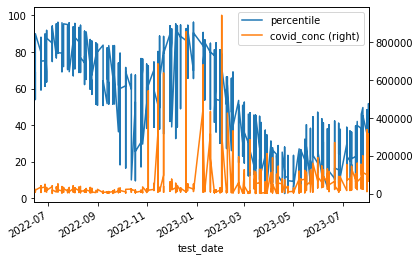

In [ ]:
import matplotlib.pyplot as plt  # Impot the relevant module

fig, ax = plt.subplots()  # Create the figure and axes object

# Plot the first x and y axes:
df.plot(x="test_date", y="percentile", ax=ax)
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
df.plot(x="test_date", y="covid_conc", ax=ax, secondary_y=True)

In [232]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
df_sk = df[(df["percentile"].notnull()) & (df["per_capita_covid_conc"].notnull())]

In [ ]:
features = df_sk["percentile"].values.reshape(-1, 1)
target = df_sk["per_capita_covid_conc"].values.reshape(-1, 1)

In [246]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=0)

In [247]:
model = LinearRegression()
model.fit(features_train, target_train)

LinearRegression()

In [248]:
target_pred = model.predict(features_test)

In [ ]:
print("Mean Absolute Error:", metrics.mean_absolute_error(target_test, target_pred))
print("Mean Squared Error:", metrics.mean_squared_error(target_test, target_pred))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(target_test, target_pred)))

Mean Absolute Error: 26303879.0271384
Mean Squared Error: 1811829201638000.2
Root Mean Squared Error: 42565587.058538266


In [190]:
cdc_df[cdc_df.wwtp_id == 551].tail(30)

,wwtp_jurisdiction,wwtp_id,key_plot_id,county_names,population_served,date_start,date_end,ptc_15d,percentile,sample_date
737985,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-07-18,2023-08-01,2.0,40.00,2023-08-01
737986,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-07-19,2023-08-02,33.0,40.00,2023-08-02
737987,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-07-20,2023-08-03,33.0,40.00,2023-08-03
737988,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-07-21,2023-08-04,33.0,40.00,2023-08-04
737989,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-07-22,2023-08-05,33.0,40.00,2023-08-05
737990,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-07-23,2023-08-06,16.0,39.00,2023-08-06
737991,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-07-24,2023-08-07,-26.0,39.00,2023-08-07
737992,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-07-25,2023-08-08,-3.0,43.75,2023-08-08
737993,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-07-26,2023-08-09,71.0,43.75,2023-08-09
737994,New York City,551,CDC_BIOBOT_ny_551_Treatment plant_post grit re...,Kings,758007,2023-07-27,2023-08-10,71.0,43.75,2023-08-10


In [189]:
nyc_df[nyc_df.wwtp_id == 551].tail()

,test_date,wrrf_name,covid_conc,per_capita_covid_conc,annotation,pop_serv_est,wwtp_id
sample_date,,,,,,,
2023-07-18,07/19/2023,Owls Head,119688.0,42500000.0,NaN,906442,551.0
2023-07-23,07/24/2023,Owls Head,79008.0,25700000.0,NaN,906442,551.0
2023-07-25,07/26/2023,Owls Head,132672.0,52600000.0,NaN,906442,551.0
2023-07-30,07/31/2023,Owls Head,205752.0,68700000.0,NaN,906442,551.0
2023-08-01,08/02/2023,Owls Head,314400.0,NaN,NaN,906442,551.0


## Wards Island??

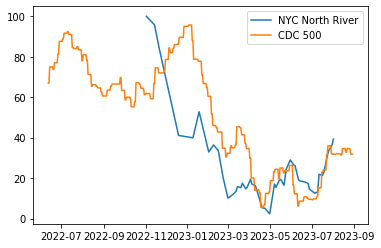

In [ ]:
plt.plot(nyc_df[nyc_df.wrrf_name == "North River"].set_index("test_date").sort_index()["est_percentile"], label="NYC North River")
plt.plot(cdc_df[cdc_df.wwtp_id == 500].set_index("test_date").sort_index()["percentile"], label="CDC 500")
plt.legend()
plt.show()

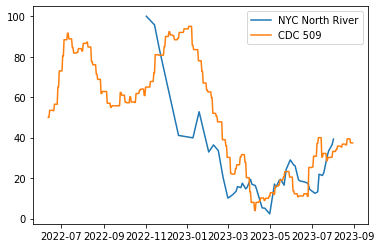

In [ ]:
plt.plot(nyc_df[nyc_df.wrrf_name == "North River"].set_index("test_date").sort_index()["est_percentile"], label="NYC North River")
plt.plot(cdc_df[cdc_df.wwtp_id == 509].set_index("test_date").sort_index()["percentile"], label="CDC 509")
plt.legend()
plt.show()

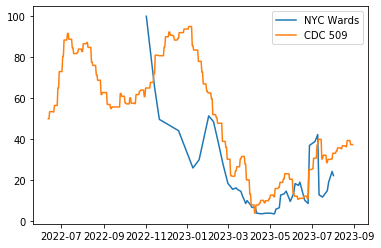

In [ ]:
plt.plot(nyc_df[nyc_df.wrrf_name == "Wards Island"].set_index("test_date").sort_index()["est_percentile"], label="NYC Wards")
plt.plot(cdc_df[cdc_df.wwtp_id == 509].set_index("test_date").sort_index()["percentile"], label="CDC 509")
plt.legend()
plt.show()

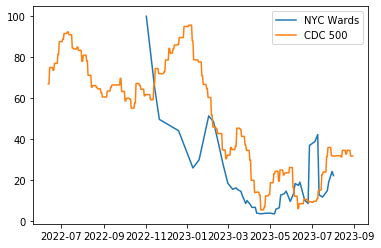

In [ ]:
plt.plot(nyc_df[nyc_df.wrrf_name == "Wards Island"].set_index("test_date").sort_index()["est_percentile"], label="NYC Wards")
plt.plot(cdc_df[cdc_df.wwtp_id == 500].set_index("test_date").sort_index()["percentile"], label="CDC 500")
plt.legend()
plt.show()

# Average Adjustment During Overlap Period

In [ ]:
pivot_df = nyc_df[(nyc_df.test_date > "2023-03-01") & (nyc_df.test_date < "2023-04-01") & (nyc_df.covid_conc > 0) & (nyc_df.covid_conc.notnull())].pivot_table(index=["wwtp_id", "test_date"], columns="Technology", values="covid_conc", aggfunc="mean").reset_index()


In [ ]:
pivot_df["diff"] = pivot_df["dPCR"] / pivot_df["RT-qPCR"]

In [ ]:
pivot_df["diff"].mean()

14.898944514646422

## Test Extracting Flow Rate

In [666]:
nyc_df[nyc_df.per_capita_covid_conc.notnull()].tail()

,Test date,wrrf_name,covid_conc,per_capita_covid_conc,annotation,pop_serv_est,Technology,test_date,wwtp_id,covid_conc_adj,cum_max,perc_test
3957,07/31/2023,Port Richmond,103608.0,40400000.0,NaN,226167,dPCR,2023-07-31,552,103608.0,433440.0,23.9
3958,07/31/2023,Red Hook,105984.0,41200000.0,NaN,224029,dPCR,2023-07-31,553,105984.0,330720.0,32.0
3959,07/31/2023,Rockaway,98232.0,71000000.0,NaN,120539,dPCR,2023-07-31,503,98232.0,941520.0,10.4
3960,07/31/2023,Tallman Island,240960.0,114000000.0,This sample was analyzed in duplicate.,449907,dPCR,2023-07-31,505,240960.0,451680.0,53.3
3961,07/31/2023,Wards Island,128088.0,83100000.0,NaN,1201485,dPCR,2023-07-31,1,128088.0,441360.0,29.0


In [ ]:
nyc_df["pc_covid_conc_wo_pop"] = nyc_df["per_capita_covid_conc"] * nyc_df["pop_serv_est"]
nyc_df["est_flow_rate"] = nyc_df["pc_covid_conc_wo_pop"] / nyc_df["covid_conc"]

In [ ]:
nyc_df[(nyc_df["est_flow_rate"].notnull()) & (nyc_df.wwtp_id == 552)].tail()

,Test date,wrrf_name,covid_conc,per_capita_covid_conc,annotation,pop_serv_est,Technology,test_date,wwtp_id,covid_conc_adj,cum_max,perc_test,pc_covid_conc_wo_pop,est_flow_rate
3901,07/17/2023,Port Richmond,35808.0,25900000.0,This sample was analyzed in duplicate.,226167,dPCR,2023-07-17,552,35808.0,433440.0,8.3,5.857725e+12,1.635871e+08
3915,07/19/2023,Port Richmond,63024.0,37400000.0,NaN,226167,dPCR,2023-07-19,552,63024.0,433440.0,14.5,8.458646e+12,1.342131e+08
3929,07/24/2023,Port Richmond,38520.0,13800000.0,NaN,226167,dPCR,2023-07-24,552,38520.0,433440.0,8.9,3.121105e+12,8.102556e+07
3943,07/26/2023,Port Richmond,30504.0,21600000.0,NaN,226167,dPCR,2023-07-26,552,30504.0,433440.0,7.0,4.885207e+12,1.601497e+08
3957,07/31/2023,Port Richmond,103608.0,40400000.0,NaN,226167,dPCR,2023-07-31,552,103608.0,433440.0,23.9,9.137147e+12,8.818959e+07


# Tried rolling before cummax

In [ ]:
def rolling_perc_dPCR(df):
    # df = df[df['technology'] == 'dPCR']
    rolling = df.set_index("test_date").groupby("wwtp_id")["covid_conc_f"].rolling("14D").mean().reset_index().rename(columns={"covid_conc_f": "covid_conc_14d"})
    rolling["cum_max"] = rolling.groupby("wwtp_id")["covid_conc_14d"].cummax()
    rolling["est_percentile"] = np.round((rolling["covid_conc_14d"] / rolling["cum_max"]) * 100, 1)
    return rolling

In [ ]:
nyc_df_pivot = nyc_df.pivot_table(index=["test_date", "wwtp_id"], columns="technology", values="covid_conc", aggfunc="max", fill_value=None)

# Define a preference order for categories
category_preference = ["RT-qPCR", "dPCR"]  # Change the order based on your preference

# Create a new column with preferred values based on the preference order
nyc_df_pivot["covid_conc_f"] = nyc_df_pivot[category_preference].bfill(axis=1).iloc[:, 0]

# Reset the index to convert 'date' back to a column
nyc_df_pivot.reset_index(inplace=True)

# Comparing sources

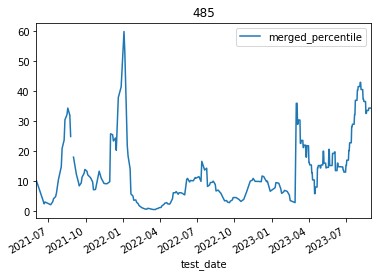

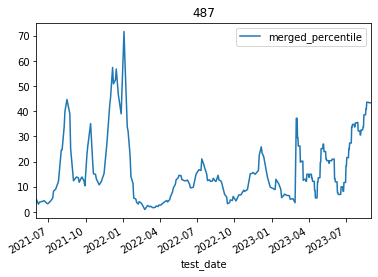

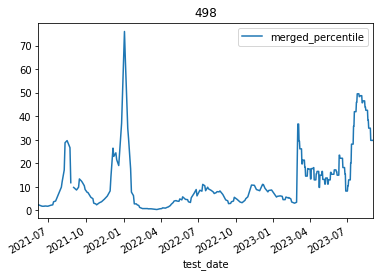

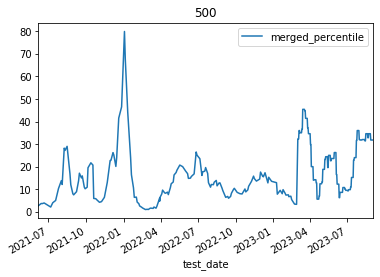

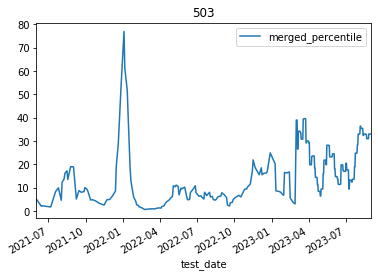

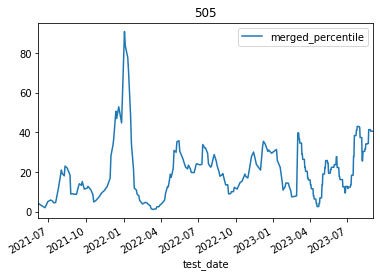

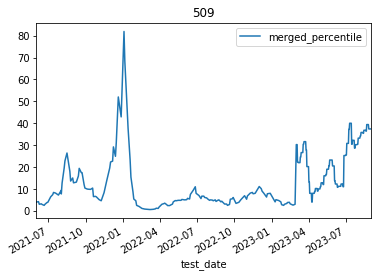

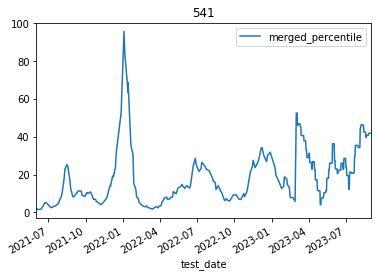

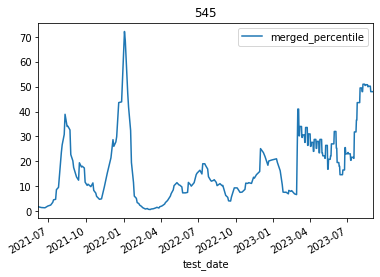

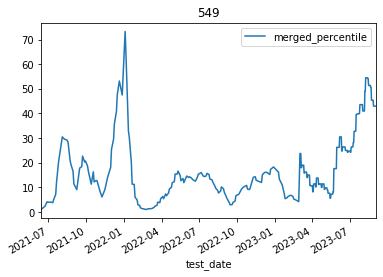

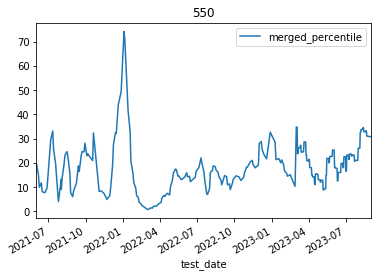

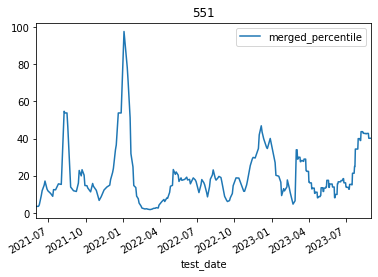

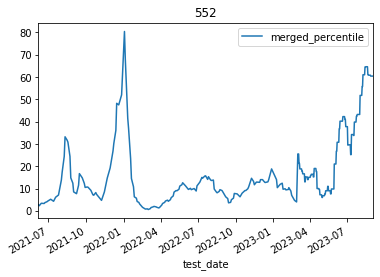

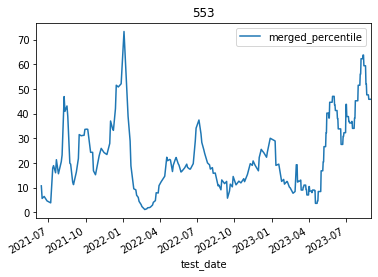

In [1131]:
for wwtp_id in [485, 487, 498, 500, 503, 505, 509, 541, 545, 549, 550, 551, 552, 553]:
    df[(df.wwtp_id == wwtp_id)].plot(x="test_date", y=["merged_percentile"], title=wwtp_id)


In [ ]:
df_corr = df
df_corr["percentile"].corr(df_corr["est_percentile"])

0.750018709236134